# Setup
In this notebook I'm going to process the sound from an interview between Kirsty Wark and Sir Elton John in attempt to determine which one of them is speaking via their gender. I would then like to overlay the p(male) or p(female) onto the video as a demonstration of my gender recognition model's capabilities.

The interview can be found here https://www.youtube.com/watch?v=nogZ4TZhHrU

In [29]:
import soundfile as sf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.signal import resample
from tqdm import tqdm_notebook as tqdm

In [2]:
assert torch.cuda.is_available()

In [3]:
import sys
sys.path.append('../')
from utils import normalise
from models import ConvNet

In [5]:
n_seconds = 3
librispeech_sampling_rate = 16000
downsampling = 4
training_sampling_rate = librispeech_sampling_rate/downsampling

# Load model

In [6]:
model = ConvNet(64, 6)
model.load_state_dict(torch.load('../models/extradata2.torch'))
model.double()
model.cuda()
model.eval()

ConvNet(
  (initialconv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (initialbn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5)

# Load data

In [7]:
interview, interview_sampling_rate = sf.read('../data/Interview.flac')
interview.shape, interview_sampling_rate

((22654400,), 44100)

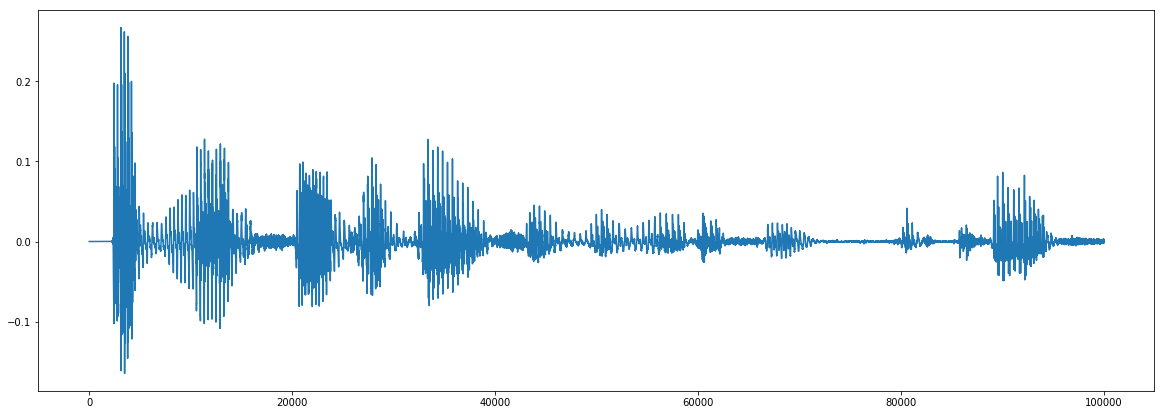

In [8]:
plt.figure(figsize=(20,7))
plt.plot(interview[:100000])
plt.show()

In [32]:
interview_duration_seconds = interview.shape[0]*1./interview_sampling_rate
interview_duration_minutes = interview_duration_seconds/60
'Interview duration is {} s'.format(interview_duration_seconds)

'Interview duration is 513.70521542 s'

In [9]:
interview_sampling_rate, training_sampling_rate

(44100, 4000)

In [10]:
training_sampling_rate*1./interview_sampling_rate

0.09070294784580499

Downsample to the sampling rate used in training of 4000 Hz.

In [11]:
resampled_interview = resample(interview,int(interview.shape[0]*training_sampling_rate*1./interview_sampling_rate))
resampled_interview.shape

(2054820,)

# Iterate through interview and generate predictions

In [58]:
pred = []
step_seconds = 0.05
step_samples = int(step_seconds*training_sampling_rate)
print 'Sample step is {}'.format(step_samples)

In [59]:
t = 0
for lower in tqdm(range(0,resampled_interview.shape[0],step_samples)):
    x = resampled_interview[lower:lower+(n_seconds*training_sampling_rate)]
    
    # Skip the very last segment which won't have the correct shape
    if x.shape != (12000,):
        continue
    
    x = normalise(x)
    y_hat = model(torch.from_numpy(x).cuda().reshape((1, 1, -1))).item()
    pred.append(y_hat)

In [62]:
segment_start_times_minutes = np.array(range(len(pred)))*0.05/60

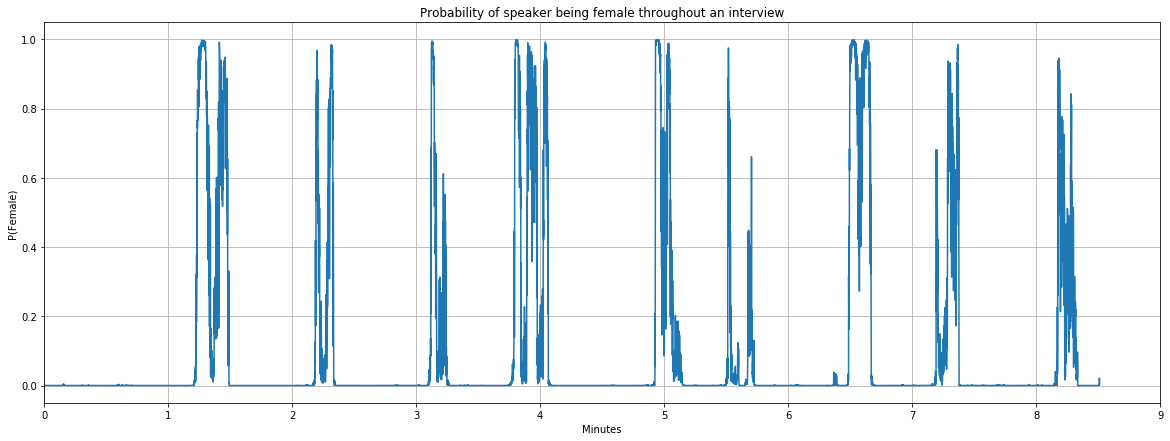

In [64]:
plt.figure(figsize=(20,7))
plt.title('Probability of speaker being female throughout an interview')
plt.plot(
    segment_start_times_minutes,
    np.array(pred)
)
plt.xlabel('Minutes')
plt.xticks(range(11))
plt.xlim((0,9))
plt.ylabel('P(Female)')
plt.grid()
plt.show()

In [65]:
df = pd.DataFrame(data={'minute': segment_start_times_minutes, 'p': pred})

In [77]:
df = df.assign(
    p_smoothed_250ms=df['p'].rolling(window=50,center=True).mean(),
    p_smoothed_100ms=df['p'].rolling(window=20,center=True).mean()
    second=df['minute'].apply(lambda m: (m % 1)*60),
    t_start=df['minute']*60,
    t_end=df['minute']*60 + 3,
    t_center=df['minute']*60 + 1.5

)

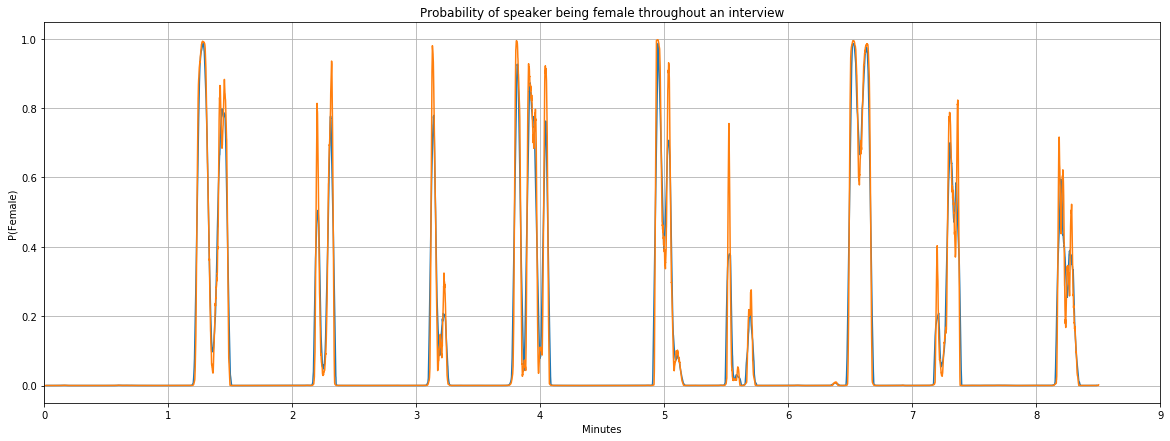

In [80]:
plt.figure(figsize=(20,7))
plt.title('Probability of speaker being female throughout an interview')
plt.plot(
    df['minute'],
    df['p_smoothed_250ms']
)
plt.plot(
    df['minute'],
    df['p_smoothed_100ms']
)
plt.xlabel('Minutes')
plt.xticks(range(11))
plt.xlim((0,9))
plt.ylabel('P(Female)')
plt.grid()
plt.show()

### Process data into start and stop times for each speaker

In [124]:
6*60 + 42

402

In [175]:
# This list of tuples represents each time in seconds the inteviewer Kirsty Wark starts and stops speaking
kirsty_start_stop = [
    (74,91),  
    (132,141),  
    (188,192),  
    (193,197),
    (228,245), 
    (293,295),  
    (297,308),
    (332,336),
    (339,340),
    (342,344),
    (390,402),
    (432,445),
    (491,502)
]
elton_john_interjections = [
    136,  # "Ughh"
    138,  # "Yeah"
    192,  # "Yeah"
    232,  # Laughs
    233,  # "Yeah"
    241,  # "Oh my god"
    242,  # "Yeah"
    307,  # "Of course"
    334,  # "Yeah"
    335,  # "Well stop using them"
    339,  # "Boycott them"
    437,  # "Nah"
]

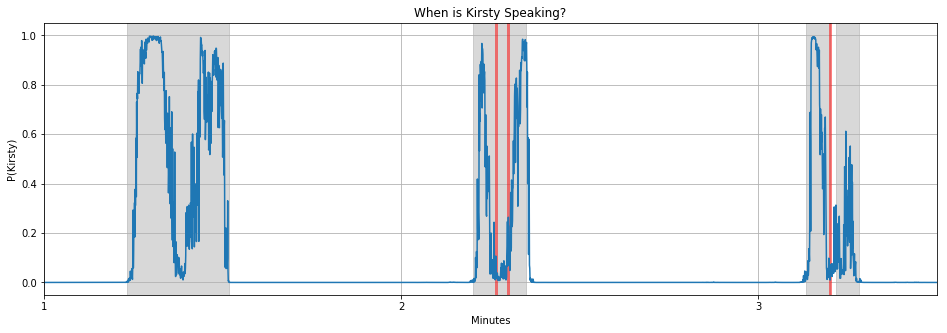

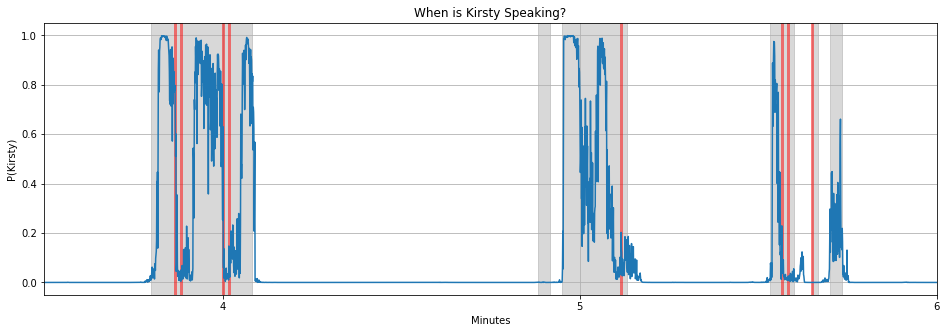

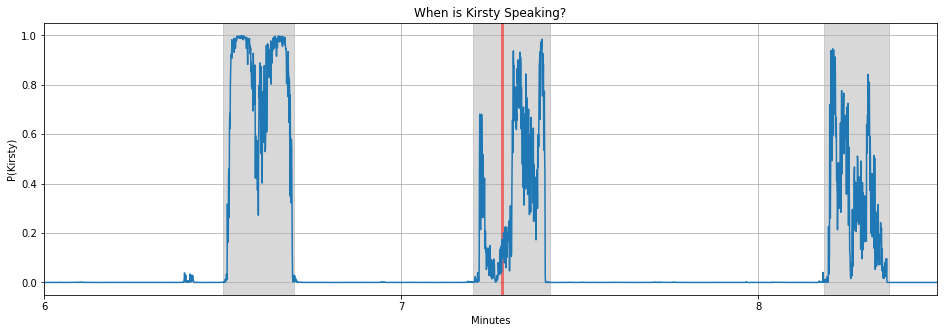

In [176]:
for start_minute in np.arange(1,8,2.5):
    plt.figure(figsize=(16,5))
    plt.title('When is Kirsty Speaking?')

    # Plot smoothed probabilities
    plt.plot(
        df['t_center']/60.,
        df['p'],
#     #     df['p_smoothed_100ms'],
#         df['p_smoothed_100ms'] > 0.08,
    )

    # Plot manual Kirsty start and stop times
    for kirsty_start_s, kirsty_stop_s in kirsty_start_stop:
        plt.fill_betweenx(
            x1=kirsty_start_s/60.,
            x2=kirsty_stop_s/60.,
            y=(-1,2),
            alpha=0.3,
            color='gray'
        )

    # Plot Elton's interjections
    plt.vlines(np.array(elton_john_interjections)/60.,-1,2,colors='r',linewidth=3,alpha=0.5)

    # Formatting
    plt.xlabel('Minutes')
    plt.xticks(range(11))
    plt.xlim((start_minute,start_minute+2.5))
    plt.ylim((-0.05,1.05))
    plt.ylabel('P(Kirsty)')
    plt.grid()
    plt.show()

# Notes

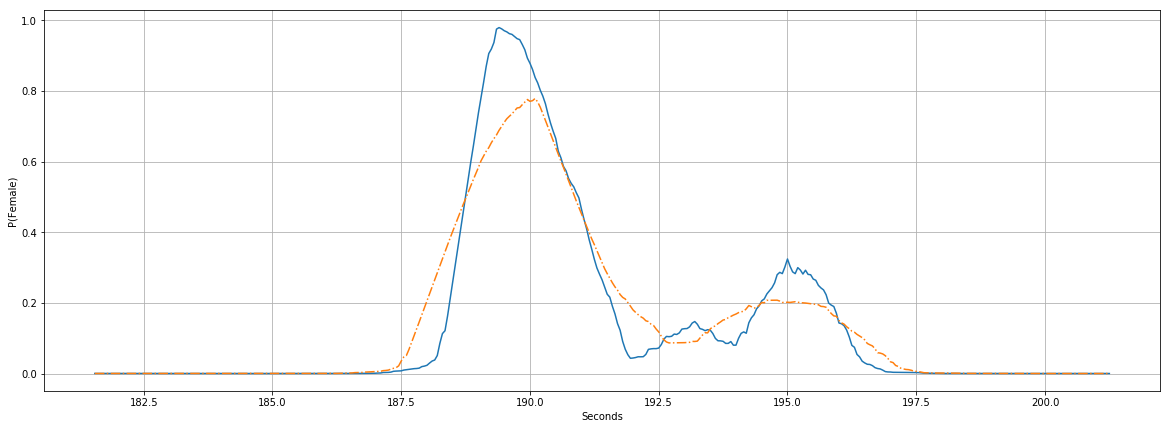

In [114]:
df_ = df[(df['minute']>3)&(df['minute']<3.33)]
plt.figure(figsize=(20,7))
plt.plot(
    df_['t_center'],
    df_['p_smoothed_100ms']
)
plt.plot(
    df_['t_center'],
    df_['p_smoothed_250ms'],
    linestyle='-.'
)
plt.xlabel('Seconds')
plt.ylabel('P(Female)')
plt.grid()
plt.show()

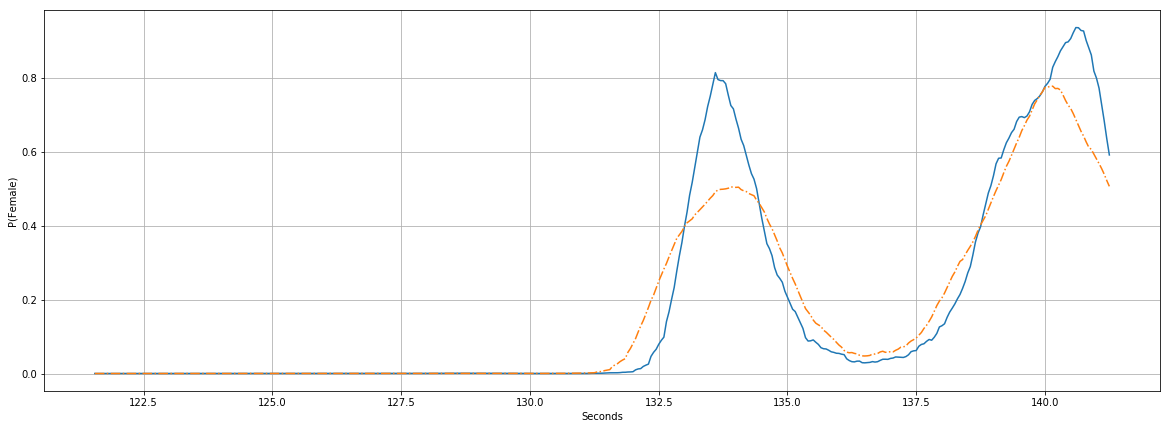

In [119]:
df_ = df[(df['minute']>2)&(df['minute']<2.33)]
plt.figure(figsize=(20,7))
plt.plot(
    df_['t_center'],
    df_['p_smoothed_100ms']
)
plt.plot(
    df_['t_center'],
    df_['p_smoothed_250ms'],
    linestyle='-.'
)
plt.xlabel('Seconds')
plt.ylabel('P(Female)')
plt.grid()
plt.show()